In [2]:
from load_data import load_clients
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderUnavailable, GeocoderTimedOut

import pgeocode
import pycountry

import tqdm


In [4]:
full_data = load_clients("clients.pkl")

In [5]:
client_labels = []
for clients in full_data:
    if clients['label']['label'] == 'Reject':
        client_labels.append(False)
    elif clients['label']['label'] == 'Accept':
        client_labels.append(True)

In [6]:
def check_client_labels(clients, flags):
    if clients['label']['label'] == 'Reject' and flags == False:
        return 1
    elif clients['label']['label'] == 'Accept' and flags == True:
        return 1
    elif clients['label']['label'] == 'Accept' and flags == False:
        print("false negative")
        return 0
    return 0
flags_preds = []       
for client in full_data:
    flags = True
    if client['passport']['first_name'] != client['account_form']['first_name']:
        flags = False
    flags_preds.append(flags)



In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np
array_flags = np.array(flags_preds)
array_labels = np.array(client_labels)
confusion_matrix(np.array(flags_preds), np.array(client_labels))

array([[ 317,    0],
       [4675, 5008]], dtype=int64)

In [6]:
full_data[0]

{'passport': {'first_name': 'Freja',
  'middle_name': 'Katrine',
  'last_name': 'Christensen',
  'gender': 'F',
  'country': 'Denmark',
  'country_code': 'DNK',
  'nationality': 'Danish',
  'birth_date': '2002-04-18',
  'passport_number': 'UE2130779',
  'passport_mrz': ['P<DNKCHRISTENSEN<<FREJA<KATRINE<<<<<<<<<<<<<<',
   'UE2130779DNK020418<<<<<<<<<<<<<<<<<<<<<<<<<<<'],
  'passport_issue_date': '2017-05-11',
  'passport_expiry_date': '2027-05-10'},
 'client_profile': {'name': 'Freja Katrine Christensen',
  'address': {'city': 'Aalborg',
   'street name': 'Strøget',
   'street number': 57,
   'postal code': '2044'},
  'country_of_domicile': 'Denmark',
  'birth_date': '2002-04-18',
  'nationality': 'Danish',
  'passport_number': 'UE2130779',
  'passport_issue_date': '2017-05-11',
  'passport_expiry_date': '2027-05-10',
  'gender': 'F',
  'phone_number': '53 11 20 42',
  'email_address': 'freja.christensen@yousee.dk',
  'marital_status': 'single',
  'secondary_school': {'name': 'Holstebro

In [56]:
def get_country_code(country_name):
    """
    Convert country name (e.g., 'Spain') to ISO Alpha-2 code (e.g., 'ES').
    """
    try:
        return pycountry.countries.lookup(country_name).alpha_2
    except LookupError:
        return None

def validate_postal_code_for_client(client_profile):
    """
    Validates if the postal code exists in the specified city and country.

    Parameters:
        client_profile (dict): Dictionary with 'address' and 'country_of_domicile'.

    Returns:
        bool: True if postal code matches the city in that country, else False.
    """
    country_names = [i.strip() for i in client_profile['country_of_domicile'].split(',')]
    address = client_profile['address']
    city = address['city'].lower()
    postal_code = address['postal code']

    flag = False
    for country_name in country_names:
        country_code = get_country_code(country_name)
        if not country_code:
            print(f"Invalid country name: {country_name}")
            continue
        else:
            nomi = pgeocode.Nominatim(country_code)
            postal_info = nomi.query_postal_code(postal_code)['postal_code']

        if postal_info is None:
            continue
        else:
            if postal_info == postal_code:
                return True
            
    return flag

def city_in_country(city, country, user_agent="city_check_app"):
    """
    Returns True if the city is located in the specified country.
    
    Parameters:
        city (str): City name
        country (str): Country name
        user_agent (str): Required for Nominatim (default is 'city_check_app')

    Returns:
        bool: True if match, False otherwise
    """
    geolocator = Nominatim(user_agent=user_agent)

    try:
        location = geolocator.geocode(f"{city}, {country}", addressdetails=True)
        if location and 'address' in location.raw:
            result_country = location.raw['address'].get('country')
            return result_country.lower() == country.lower()
        else:
            return False
    except (GeocoderUnavailable, GeocoderTimedOut):
        return False
    
def validate_city_in_country(client_profile):
    country_names = [i.strip() for i in client_profile['country_of_domicile'].split(',')]
    address = client_profile['address']
    city = address['city'].lower()

    for country in country_names:
        belongs = city_in_country(city, country)
        if belongs:
            return True
    
    return False



In [81]:
for ind, client in enumerate(full_data):
    if not isinstance(client['client_profile']['address']['city'], str) or not isinstance(client['client_profile']['country_of_domicile'], str):
        print(ind, client['client_profile']['address']['city'], client['client_profile']['country_of_domicile'])
    if len(client['client_profile']['address']['city'].split(',')) > 1 or len(client['client_profile']['country_of_domicile'].split(',')) > 1:
        print(ind, client['client_profile']['address']['city'], client['client_profile']['country_of_domicile'])

220 Gladsaxe Denmark,France
288 Brugg Switzerland,Spain
504 Rauma Finland,France
1152 Hyvinkää Finland,Italy
1289 Nice France,Germany
1527 Bordeaux France,Switzerland
1616 Vienna Austria,Italy
1675 Turin Italy,Germany
1706 Clermont-Ferrand France,Germany
1950 Florence Italy,Netherlands
2149 Leipzig Germany,Belgium
2216 Clermont-Ferrand France,Switzerland
2354 Eindhoven Netherlands,Finland
3001 Dresden Germany,Netherlands
3125 Saalfelden Austria,France
3241 Ikast Denmark,France
3248 Strasbourg France,Spain
3334 Jyväskylä Finland,Italy
3892 Haarlem Netherlands,Austria
3916 Leipzig Germany,Netherlands
3970 Metz France,Switzerland
4068 Joensuu Finland,Switzerland
4085 Maastricht Netherlands,Germany
4649 Copenhagen Denmark,Germany
4873 Liège Belgium,Finland
4893 Binche Belgium,Denmark
5050 Brugg Switzerland,Finland
5250 Hillerød Denmark,Germany
5260 Wels Austria,Germany
5415 Oss Netherlands,Italy
5524 Porvoo Finland,Austria
5556 Geel Belgium,Italy
5578 Hyvinkää Finland,Switzerland
5737 Hoof

In [58]:
%%time
client_profile = full_data[1328]['client_profile']
validate_postal_code_for_client(client_profile)

Wall time: 310 ms


True

In [ ]:
# Optional: Cache pgeocode instances for each country to speed up repeated use
_nomi_cache = {}

def get_country_code(country_name):
    """
    Convert a full country name (e.g., 'Spain') to ISO Alpha-2 code (e.g., 'ES').

    Returns:
        str or None: ISO Alpha-2 code or None if not found.
    """
    try:
        return pycountry.countries.lookup(country_name).alpha_2
    except LookupError:
        return None

def get_nomi_instance(country_code):
    """
    Return a cached pgeocode.Nominatim instance for the given country.
    """
    if country_code not in _nomi_cache:
        _nomi_cache[country_code] = pgeocode.Nominatim(country_code)
    return _nomi_cache[country_code]

def validate_postal_code_for_client(client_profile, check_city=False):
    """
    Validates if the postal code exists in the provided city and country.

    Parameters:
        client_profile (dict): Must include 'address' and 'country_of_domicile'.
        check_city (bool): if true we use this function to find whther city really belongs to the country

    Returns:
        bool: True if postal code matches the city in any listed country, else False.
    """
    country_names = [name.strip() for name in client_profile.get('country_of_domicile', '').split(',')]
    address = client_profile.get('address', {})
    city = address.get('city', '').lower()
    postal_code = address.get('postal code', '')

    if check_city:
        for country_name in country_names:
            country_code = get_country_code(country_name)
            if not country_code:
                continue  # Skip invalid countries

            nomi = get_nomi_instance(country_code)
            df = nomi._data

            if df is None or df.empty:
                continue
            
            # Convert to NumPy array and use list comprehension (still fast)
            col_values = df[['place_name', 'postal_code']].values
            mask1 = [val_pair[0].lower() in city or city in val_pair[0].lower() in city for val_pair in col_values]
            df = df[mask1]

            if not df.empty:
                return True
            
        return False

    for country_name in country_names:
        country_code = get_country_code(country_name)
        if not country_code:
            continue  # Skip invalid countries

        nomi = get_nomi_instance(country_code)
        df = nomi._data

        if df is None or df.empty:
            continue
        
        # Convert to NumPy array and use list comprehension (still fast)
        col_values = df[['place_name', 'postal_code']].values
        # mask1 = [val_pair[1] == postal_code and val_pair[0] in city for val_pair in col_values]
        mask1 = [val_pair[1] == postal_code for val_pair in col_values]
        df = df[mask1]

        if not df.empty:
            return True
        
        # postal_info = nomi.query_postal_code(postal_code)['postal_code']

        # if postal_info is None:
        #     continue

        # # matched_cities = [c.strip().lower() for c in postal_info.place_name.split(',')]
        # if postal_info == postal_code:
        #     return True  # Valid match

    return False  # No match found


In [38]:
client_profile = full_data[1328]['client_profile']
country_names = [name.strip() for name in client_profile.get('country_of_domicile', '').split(',')]
address = client_profile.get('address', {})
city = address.get('city', '').lower()
postal_code = address.get('postal code', '')
city

'madrid'

In [29]:
%%time
client_profile = full_data[1328]['client_profile']
validate_postal_code_for_client(client_profile)

Wall time: 129 ms


False

In [63]:
full_data[1328]['client_profile']

{'name': 'López Sánchez González',
 'address': {'city': 'Madrid',
  'street name': 'Calle de la Princesa',
  'street number': 39,
  'postal code': '71374'},
 'country_of_domicile': 'Spain',
 'birth_date': '1958-12-06',
 'nationality': 'Spanish',
 'passport_number': 'RT9557035',
 'passport_issue_date': '2021-03-03',
 'passport_expiry_date': '2031-03-02',
 'gender': 'M',
 'phone_number': '682 616 065',
 'email_address': 'lopez.gonzalez@vodafone.es',
 'marital_status': 'married',
 'secondary_school': {'name': 'Colegio San Ignacio de Loyola Valencia',
  'graduation_year': 1977},
 'higher_education': [{'university': 'University of Seville',
   'graduation_year': 1982}],
 'employment_history': [{'start_year': 1982,
   'end_year': 1984,
   'company': 'Esteve Teijin Healthcare S.L.',
   'position': 'Research Scientist',
   'salary': 24000},
  {'start_year': 1985,
   'end_year': 2019,
   'company': 'Almirall S.A.',
   'position': 'Clinical Trials Manager',
   'salary': 248000}],
 'aum': {'savin

In [40]:
def check_client_labels(clients, flags):
    if clients['label']['label'] == 'Reject' and flags == False:
        return 1
    elif clients['label']['label'] == 'Accept' and flags == True:
        return 1
    elif clients['label']['label'] == 'Accept' and flags == False:
        print("false negative")
        return 0
    return 0

# Address , zip code flag
# flags_preds = []       
# for client in full_data:
#     flags = True
#     if validate_postal_code_for_client(client['client_profile']):
#         flags = False
#     flags_preds.append(flags)


# City, Country flag
flags_preds = []       
i = 0
for client in full_data:
    print(i)
    flags = True
    if not validate_postal_code_for_client(client['client_profile'], check_city=True):
        flags = False
    flags_preds.append(flags)
    i+=1




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [41]:
array_flags = np.array(flags_preds)
array_labels = np.array(client_labels)
confusion_matrix(np.array(flags_preds), np.array(client_labels))

array([[ 594,  594],
       [4398, 4414]], dtype=int64)

In [44]:
flags_preds = []       
for ind, client in enumerate(full_data):
    flags = True
    if client['account_form']['address']['postal code'] != client['client_profile']['address']['postal code']:
        # print(ind)
        flags = False
    flags_preds.append(flags)


In [45]:
array_flags = np.array(flags_preds)
array_labels = np.array(client_labels)
confusion_matrix(np.array(flags_preds), np.array(client_labels))

array([[  70,    0],
       [4922, 5008]], dtype=int64)

In [9]:
full_data[1328]['client_profile']['aum']

{'savings': 530000, 'inheritance': 0, 'real_estate_value': 1400000}

In [10]:
def get_unique_keys(clients):
    """
    Returns a set of all unique keys from a list of flat dictionaries.
    """
    unique_keys = set()
    for client in clients:
        d = client['client_profile']['aum']
        unique_keys.update(d.keys())
    return unique_keys

get_unique_keys(full_data)

{'inheritance', 'real_estate_value', 'savings'}

In [13]:

for id, client in enumerate(full_data):
    
    if client['client_profile']['aum']['real_estate_value'] != 0:
        total_value = 0
        for property in client['client_profile']['real_estate_details']:
            total_value += property['property value']
        if total_value != client['client_profile']['aum']['real_estate_value']:
            print(id, client['client_profile']['aum']['real_estate_value'], total_value, client['label']['label'])

In [16]:
nomi = get_nomi_instance("ES")

In [22]:
full_data[1328]['client_profile']

{'name': 'López Sánchez González',
 'address': {'city': 'Madrid',
  'street name': 'Calle de la Princesa',
  'street number': 39,
  'postal code': '71374'},
 'country_of_domicile': 'Spain',
 'birth_date': '1958-12-06',
 'nationality': 'Spanish',
 'passport_number': 'RT9557035',
 'passport_issue_date': '2021-03-03',
 'passport_expiry_date': '2031-03-02',
 'gender': 'M',
 'phone_number': '682 616 065',
 'email_address': 'lopez.gonzalez@vodafone.es',
 'marital_status': 'married',
 'secondary_school': {'name': 'Colegio San Ignacio de Loyola Valencia',
  'graduation_year': 1977},
 'higher_education': [{'university': 'University of Seville',
   'graduation_year': 1982}],
 'employment_history': [{'start_year': 1982,
   'end_year': 1984,
   'company': 'Esteve Teijin Healthcare S.L.',
   'position': 'Research Scientist',
   'salary': 24000},
  {'start_year': 1985,
   'end_year': 2019,
   'company': 'Almirall S.A.',
   'position': 'Clinical Trials Manager',
   'salary': 248000}],
 'aum': {'savin

In [24]:
nomi._data.loc[(nomi._data['place_name'] == 'Madrid') & (nomi._data['postal_code'] == 71374)]

Empty DataFrame
Columns: [country_code, postal_code, place_name, state_name, state_code, county_name, county_code, community_name, community_code, latitude, longitude, accuracy]
Index: []

In [26]:
nomi._data.loc[(nomi._data['place_name'] == 'Madrid')]

country_code postal_code place_name state_name state_code county_name  \
519             ES       04810     Madrid  Andalucia         AN     Almería   
32781           ES       28001     Madrid     Madrid         MD      Madrid   
32782           ES       28002     Madrid     Madrid         MD      Madrid   
32783           ES       28003     Madrid     Madrid         MD      Madrid   
32784           ES       28004     Madrid     Madrid         MD      Madrid   
...            ...         ...        ...        ...        ...         ...   
32840           ES       28082     Madrid     Madrid         MD      Madrid   
32841           ES       28083     Madrid     Madrid         MD      Madrid   
32842           ES       28085     Madrid     Madrid         MD      Madrid   
32843           ES       28086     Madrid     Madrid         MD      Madrid   
32844           ES       28087     Madrid     Madrid         MD      Madrid   

      county_code community_name  community_code  latitude  longitude  \
519            AL           Oria          4070.0   37.4375    -2.2560   
32781           M         Madrid         28079.0   40.4255    -3.6834   
32782           M         Madrid         28079.0   40.4465    -3.6751   
32783           M         Madrid         28079.0   40.4423    -3.7046   
32784           M         Madrid         28079.0   40.4241    -3.7007   
...           ...            ...             ...       ...        ...   
32840           M            NaN             NaN   40.4165    -3.7026   
32841           M            NaN             NaN   40.4165    -3.7026   
32842           M            NaN             NaN   40.4165    -3.7026   
32843           M            NaN             NaN   40.4165    -3.7026   
32844           M            NaN             NaN   40.4165    -3.7026   

       accuracy  
519           3  
32781         4  
32782         4  
32783         4  
32784         4  
...         ...  
32840         4  
32841         4  
32842         4  
32843         4  
32844         4  

[64 rows x 12 columns]

In [47]:
for client in full_data:
    if client['client_profile']['aum']['inheritance'] == 0:
        print(client['client_profile']['aum'])
    

{'savings': 2910000, 'inheritance': 0, 'real_estate_value': 5940000}
{'savings': 490000, 'inheritance': 0, 'real_estate_value': 3529000}
{'savings': 1710000, 'inheritance': 0, 'real_estate_value': 0}
{'savings': 1740000, 'inheritance': 0, 'real_estate_value': 1860000}
{'savings': 1740000, 'inheritance': 0, 'real_estate_value': 2817000}
{'savings': 560000, 'inheritance': 0, 'real_estate_value': 3820000}
{'savings': 830000, 'inheritance': 0, 'real_estate_value': 1060000}
{'savings': 1040000, 'inheritance': 0, 'real_estate_value': 4890000}
{'savings': 520000, 'inheritance': 0, 'real_estate_value': 2330000}
{'savings': 720000, 'inheritance': 0, 'real_estate_value': 1977000}
{'savings': 1100000, 'inheritance': 0, 'real_estate_value': 3620000}
{'savings': 960000, 'inheritance': 0, 'real_estate_value': 1730000}
{'savings': 820000, 'inheritance': 0, 'real_estate_value': 4021000}
{'savings': 1690000, 'inheritance': 0, 'real_estate_value': 1831000}
{'savings': 4680000, 'inheritance': 0, 'real_es

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\aliak\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

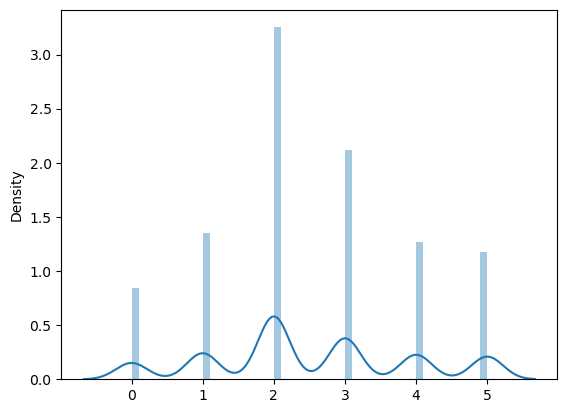

In [68]:
sns.distplot([len(client['client_profile']['employment_history']) for client in full_data])

In [63]:
full_data[0]['client_profile']['employment_history']

[]

In [64]:
full_data[0]['client_profile']['birth_date']

'2002-04-18'

In [65]:
full_data[0]['label']['label']

'Accept'

In [74]:
full_data[1352]['client_profile']['employment_history']

[{'start_year': 2010,
  'end_year': 2011,
  'company': 'Valmet Oyj',
  'position': 'Plant Manager',
  'salary': 39000},
 {'start_year': 2012,
  'end_year': None,
  'company': 'Konecranes Oyj',
  'position': 'Operations Director',
  'salary': 152000}]

In [93]:
isinstance(full_data[1]['client_profile']['employment_history'][0]['salary'], int)

True

In [ ]:
def calculate_effective_experience(jobs):
    """
    Calculates total work experience in years, avoiding double-counting overlapping years.

    Parameters:
        jobs (list of tuples): Each tuple is (start_year, end_year or None)

    Returns:
        int: Total number of unique active years worked
    """
    worked_years = set()

    for start, end in jobs:
        if start is None:
            continue  # Skip invalid entries
        end = end if end is not None else 2025
        # Add each year in the range [start, end)
        worked_years.update(range(start, end))

    return len(worked_years)

calculate_effective_experience([(2012,2015), (2017, 2023), (2021, 2023)])

9

In [100]:
0>-np.inf

True

In [111]:
# current_salary_vec
# max_salary_vec
# total_work_experience_vec
# effective_work_experience_vec
len(effective_work_experience_vec)

10000

In [86]:
current_salary_vec = [0 if len(client['client_profile']['employment_history']) == 0 else client['client_profile']['employment_history'][-1]['salary'] for client in full_data]

In [87]:
for ind, sal in enumerate(salary_vec):
    if sal != current_salary_vec[ind]:
        print(ind, sal, current_salary_vec[ind])

2 71000 125000
11 231000 736000
12 231000 1814000
13 231000 236000
14 231000 940000
15 231000 891000
16 231000 988000
21 912000 276000
24 180000 74000
25 180000 313000
26 180000 479000
27 180000 392000
28 180000 1905000
34 590000 595000
37 3058000 261000
40 304000 89000
41 304000 388000
42 304000 193000
43 304000 636000
44 304000 540000
45 304000 80000
46 304000 400000
49 1200000 1011000
50 1200000 1296000
51 1200000 2206000
63 0 71000
68 33000 2317000
73 0 1161000
80 79000 507000
82 0 748000
83 0 496000
92 30000 342000
93 30000 531000
101 200000 54000
106 29000 534000
108 86000 556000
111 959000 991000
113 526000 57000
123 453000 667000
124 453000 3875000
126 53000 864000
128 534000 364000
132 46000 197000
138 0 356000
139 0 749000
145 160000 498000
154 37000 352000
155 37000 256000
166 154000 504000
167 154000 613000
170 38000 8798000
171 38000 1251000
181 304000 1078000
183 0 1048000
186 0 466000
187 0 6187000
189 58000 2213000
191 292000 70000
193 64000 483000
194 64000 760000
203 

In [98]:
full_data[1352]['client_profile']['real_estate_details']

[{'property type': 'condo',
  'property value': 995000,
  'property location': 'Kuopio'},
 {'property type': 'condo',
  'property value': 850000,
  'property location': 'Sipoo'}]

In [116]:
aum_vec = [np.sum(list(client['client_profile']['aum'].values())) for client in full_data]
property_value_vec = [client['client_profile']['aum']['real_estate_value'] for client in full_data]
property_count_vec = [len(client['client_profile']['real_estate_details']) for client in full_data]
inheritance_vec = [client['client_profile']['aum']['inheritance'] for client in full_data]
savings_vec = [client['client_profile']['aum']['savings'] for client in full_data]
job_count = [len(client['client_profile']['employment_history']) for client in full_data]
current_salary_vec = [0 if len(client['client_profile']['employment_history']) == 0 else client['client_profile']['employment_history'][-1] for client in full_data]
property_to_cash_vec = [
    prop_value / (total_value - prop_value) if (total_value - prop_value) != 0 else -float('inf')
    for prop_value, total_value in zip(property_value_vec, aum_vec)
]
max_ratio = np.max(property_to_cash_vec)
property_to_cash_vec = [max_ratio if value == -float("inf") else value for value in property_to_cash_vec]

In [118]:
len(property_to_cash_vec)

10000

In [114]:
np.sum([1 if value == -float("inf") else 0 for value in property_to_cash_vec])

0

In [113]:
np.max(property_to_cash_vec)

158.33333333333334

In [121]:
full_data

[{'passport': {'first_name': 'Freja',
   'middle_name': 'Katrine',
   'last_name': 'Christensen',
   'gender': 'F',
   'country': 'Denmark',
   'country_code': 'DNK',
   'nationality': 'Danish',
   'birth_date': '2002-04-18',
   'passport_number': 'UE2130779',
   'passport_mrz': ['P<DNKCHRISTENSEN<<FREJA<KATRINE<<<<<<<<<<<<<<',
    'UE2130779DNK020418<<<<<<<<<<<<<<<<<<<<<<<<<<<'],
   'passport_issue_date': '2017-05-11',
   'passport_expiry_date': '2027-05-10'},
  'client_profile': {'name': 'Freja Katrine Christensen',
   'address': {'city': 'Aalborg',
    'street name': 'Strøget',
    'street number': 57,
    'postal code': '2044'},
   'country_of_domicile': 'Denmark',
   'birth_date': '2002-04-18',
   'nationality': 'Danish',
   'passport_number': 'UE2130779',
   'passport_issue_date': '2017-05-11',
   'passport_expiry_date': '2027-05-10',
   'gender': 'F',
   'phone_number': '53 11 20 42',
   'email_address': 'freja.christensen@yousee.dk',
   'marital_status': 'single',
   'secondary

In [119]:
df_numeric = pd.DataFrame()

# # label Accept/Reject
# label = [client['label']['label'] for client in full_data]


aum_vec = [np.sum(list(client['client_profile']['aum'].values())) for client in full_data]
property_value_vec = [client['client_profile']['aum']['real_estate_value'] for client in full_data]
property_count_vec = [len(client['client_profile']['real_estate_details']) for client in full_data]
inheritance_vec = [client['client_profile']['aum']['inheritance'] for client in full_data]
savings_vec = [client['client_profile']['aum']['savings'] for client in full_data]
job_count_vec = [len(client['client_profile']['employment_history']) for client in full_data]
property_to_cash_vec = [
    prop_value / (total_value - prop_value) if (total_value - prop_value) != 0 else -float('inf')
    for prop_value, total_value in zip(property_value_vec, aum_vec)
]
max_ratio = np.max(property_to_cash_vec)
property_to_cash_vec = [max_ratio if value == -float("inf") else value for value in property_to_cash_vec]

inheritance_to_cash_vec = [inheritance/(inheritance+saving) if inheritance+saving != 0 else 0 for inheritance, saving in zip(inheritance_vec, savings_vec)]

current_salary_vec = []
max_salary_vec = []
total_work_experience_vec = []
effective_work_experience_vec = []

def calculate_effective_experience(jobs):
    """
    Calculates total work experience in years, avoiding double-counting overlapping years.

    Parameters:
        jobs (list of tuples): Each tuple is (start_year, end_year or None)

    Returns:
        int: Total number of unique active years worked
    """
    worked_years = set()

    for start, end in jobs:
        if start is None:
            continue  # Skip invalid entries
        end = end if end is not None else 2025
        # Add each year in the range [start, end)
        worked_years.update(range(start, end))

    return len(worked_years)


for ind, client in enumerate(full_data):
    emp_hist = client['client_profile']['employment_history']
    salary = 0
    max_salary = 0
    if len(emp_hist) == 0:
        total_work_experience = 0
        effective_work_experience = 0
    else:
        year_history = []
        min_start = np.inf
        max_end = -np.inf
        for job in emp_hist:
            if max_salary < job['salary']:
                max_salary = job['salary']

            start, end = job['start_year'], job['end_year']

            year_history.append((start, end))

            if end is None:
                salary += job['salary']
                end = 2025

            if start < min_start:
                min_start = start
            if end > max_end:
                max_end = end

        total_work_experience = max_end-min_start
        effective_work_experience = calculate_effective_experience(year_history)

    effective_work_experience_vec.append(calculate_effective_experience(year_history))
    total_work_experience_vec.append(max_end-min_start)
    current_salary_vec.append(salary)
    max_salary_vec.append(max_salary)


saving_per_annum_vec = [saving/work_exp if work_exp != 0 else saving for saving, work_exp in zip(savings_vec, effective_work_experience_vec)]
salary_to_max_salary_vec = [salary/max_salary if max_salary != 0 else 0 for max_salary, salary in zip(max_salary_vec, current_salary_vec)]

df_numeric = pd.DataFrame({
    'aum': aum_vec,
    'property_value': property_value_vec,
    'num_properties': property_count_vec,
    'inheritance_value': inheritance_vec,
    'savings_value': savings_vec,
    'num_jobs': job_count_vec,
    'current_salary': current_salary_vec,
    'max_salary': max_salary_vec,
    'property_to_cash_ratio': property_to_cash_vec,
    'inheritance_to_cash_ratio': inheritance_to_cash_vec,
    'total_work_experience': total_work_experience_vec,
    'effective_work_experience': effective_work_experience_vec,
    'saving_per_annum': saving_per_annum_vec,
    'salary_to_max_salary_ratio': salary_to_max_salary_vec
})
    

In [120]:
df_numeric.shape

(10000, 14)

In [70]:
[0 if len(i) == 0 else i[-1] for i in [[], [1,2,3], [12], []]]

[0, 3, 12, 0]

In [60]:
label = [client['label']['label'] for client in full_data]